In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [49]:
import pyspark
from pyspark.sql import SparkSession

sc = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## read dataset

In [4]:
data = sc.read \
  .option('header', 'True')\
  .option('inferSchema', 'True')\
  .option('sep', ',')\
  .csv('/content/drive/MyDrive/data.csv')

In [5]:
data = data.distinct()

## data shape

In [ ]:
print('number of rows: '+ str(data.count()))
print('number of columns: '+ str(len(data.columns)))

number of rows: 229990
number of columns: 21


## data types

In [ ]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'double'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'double'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Label', 'string')]

## distribution of data in target classes

In [ ]:
data.groupby('Label').count().show()

+-----+------+
|Label| count|
+-----+------+
| null|   208|
|   No|195878|
|  Yes| 33904|
+-----+------+



In [ ]:
print(100*(208/229990))
print(100*(195878/229990))
print(100*(33904/229990))

0.09043871472672725
85.16805078481673
14.741510500456542


## split dataset based on numeric and categorical

In [32]:
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

categorical_columns = []
for col in data.columns:
  if col not in numeric_features:
    categorical_columns.append(col)

numeric_df = data.drop(*tuple(categorical_columns))
categorical_df = data.drop(*tuple(numeric_features))

## explore numeric features

In [ ]:
numeric_df.describe().show()

+-------+-------------------+-----------------+------------------+-----------------+
|summary|      SeniorCitizen|           tenure|    MonthlyCharges|     TotalCharges|
+-------+-------------------+-----------------+------------------+-----------------+
|  count|             229724|           229765|            229747|           229739|
|   mean|0.21505371663387368|49.43501838835332|126.33354646633397|3700.323704725759|
| stddev| 0.8971977539088728|36.63299614293823| 856.9228133633635|2326.036263404356|
|    min|                0.0|           -598.0|             18.25|             18.8|
|    max|               17.0|             72.0|           14990.0|           8684.8|
+-------+-------------------+-----------------+------------------+-----------------+



## correlation of numeric features

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

my_cols =numeric_df.select(numeric_df.columns)
new_df = my_cols.na.drop()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(new_df).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

df = sc.createDataFrame(corrmatrix,numeric_features)
df.show()

+--------------------+--------------------+--------------------+-------------------+
|       SeniorCitizen|              tenure|      MonthlyCharges|       TotalCharges|
+--------------------+--------------------+--------------------+-------------------+
|                 1.0|0.021968033406082374|-2.35081944281545...|0.07035394107959646|
|0.021968033406082374|                 1.0|0.015090136155424226|0.35527680076386325|
|-2.35081944281545...|0.015090136155424226|                 1.0|0.06140509301362273|
| 0.07035394107959646| 0.35527680076386325| 0.06140509301362273|                1.0|
+--------------------+--------------------+--------------------+-------------------+



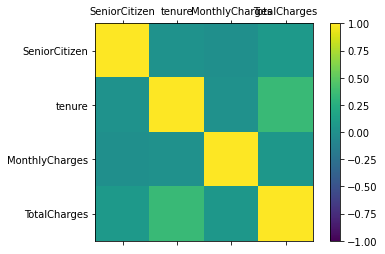

In [ ]:
import matplotlib.pyplot as plt

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    # ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, numeric_features, 234)

In [ ]:
numeric_df.corr('tenure', 'TotalCharges')

0.3555748497348355

## Label Encoding 'Label' column

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

y_udf = udf(lambda y:0 if y=='No' else 1, IntegerType()) 
df = data.withColumn('Churn', y_udf('Label')).drop('Label')
df = df.drop(*tuple(categorical_columns))
df

DataFrame[SeniorCitizen: double, tenure: double, MonthlyCharges: double, TotalCharges: double, Churn: int]

+--------------------+--------------------+--------------------+--------------------+--------------------+
|       SeniorCitizen|              tenure|      MonthlyCharges|        TotalCharges|               Churn|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.30812081595993385|-0.33269149338862763|-0.27004203828113194|-0.06928904197775006|
|-0.30812081595993385|                 1.0| -0.2808845267851059| 0.45683412495147235| -0.5963793102723218|
|-0.33269149338862763| -0.2808845267851059|                 1.0| -0.2514596772333894|-0.23512255699051182|
|-0.27004203828113194| 0.45683412495147235| -0.2514596772333894|                 1.0| -0.4883760070158531|
|-0.06928904197775006| -0.5963793102723218|-0.23512255699051182| -0.4883760070158531|                 1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+



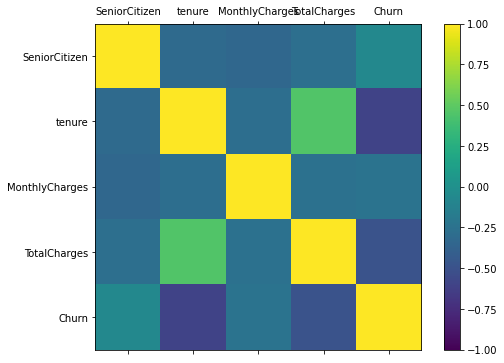

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

my_cols =df.select(df.columns)
new_df = my_cols.na.drop()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(new_df).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

df = sc.createDataFrame(corrmatrix,df.columns)
df.show()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(figsize=(8, 6))
    ax=fig.add_subplot(111)
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, df.columns, 234)

## overlaid histogram of continuous features

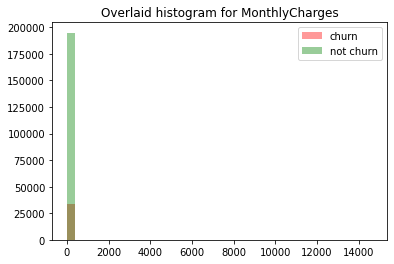

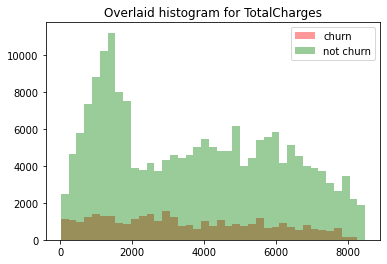

In [ ]:
import numpy as np
from pyspark.sql.functions import col

for i in ['MonthlyCharges', 'TotalCharges']:
    churn = df.filter(col("Churn")==1).select(i)
    not_churn = df.filter(col("Churn")==0).select(i)
    xmin = min(churn.agg({i:'min'}).collect()[0][0], not_churn.agg({i:'min'}).collect()[0][0])
    xmax = max(churn.agg({i:'max'}).collect()[0][0], not_churn.agg({i:'max'}).collect()[0][0])
    width = (xmax - xmin) / 40
    sns.distplot(churn.toPandas(), color='r', kde=False, bins=np.arange(xmin, xmax, width, dtype=float))
    sns.distplot(not_churn.toPandas(), color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['churn', 'not churn'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

In [ ]:
a = df.filter(col("SeniorCitizen")== 17.0).count()
a

6

In [ ]:
df.select('SeniorCitizen').distinct().collect()

[Row(SeniorCitizen=0.0),
 Row(SeniorCitizen=None),
 Row(SeniorCitizen=1.0),
 Row(SeniorCitizen=14.0),
 Row(SeniorCitizen=17.0)]

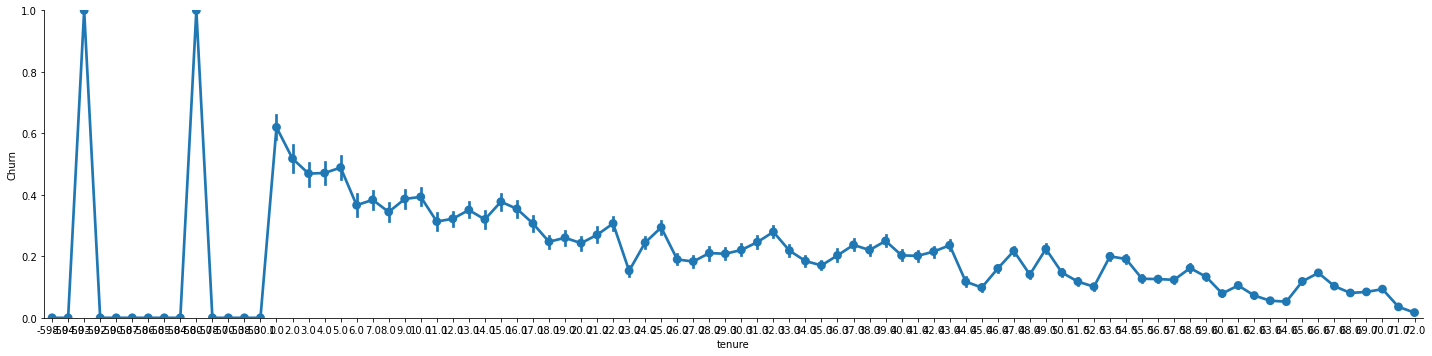

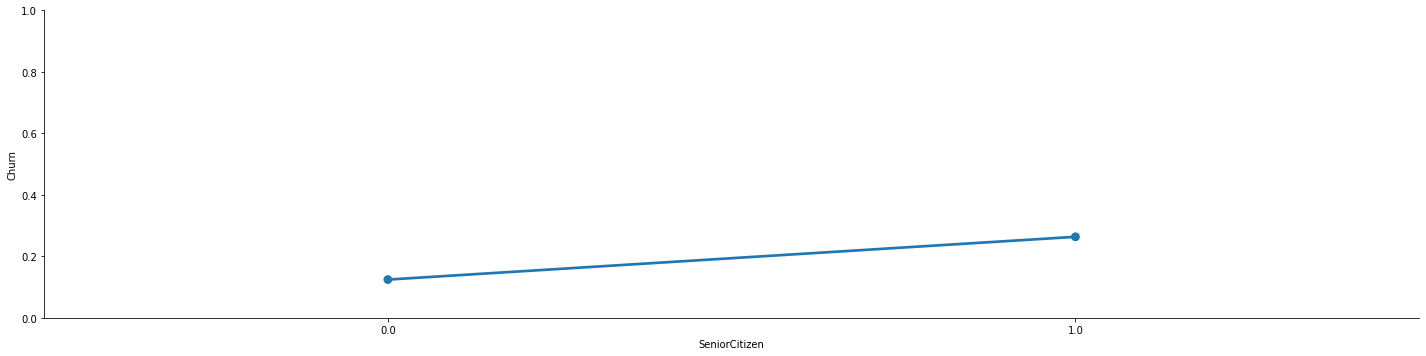

In [ ]:
from pyspark.sql.readwriter import DataFrameWriterV2
import seaborn as sns
import matplotlib.pyplot as plt

df2 = df.filter(
    ((df.SeniorCitizen != 14.0)
     & (df.SeniorCitizen != 17.0))
)


for col in ['tenure', 'SeniorCitizen']:
  sns.catplot(x=col, y = 'Churn', data = df2.toPandas(), kind = 'point', aspect=4, )
  plt.ylim(0,1)

# categorical features

In [ ]:
for col in categorical_columns:
  count = categorical_df.select(col).distinct().count()
  print(col + ': '+ str(count)+ ' unique values')



customerID: 7066 unique values
gender: 3 unique values
Partner: 3 unique values
Dependents: 3 unique values
PhoneService: 3 unique values
MultipleLines: 4 unique values
InternetService: 4 unique values
OnlineSecurity: 4 unique values
OnlineBackup: 4 unique values
DeviceProtection: 4 unique values
TechSupport: 4 unique values
StreamingTV: 4 unique values
StreamingMovies: 4 unique values
Contract: 4 unique values
PaperlessBilling: 3 unique values
PaymentMethod: 5 unique values
Label: 2 unique values


In [ ]:
y_udf = udf(lambda y:0 if y=='No' else 1, IntegerType()) 
df = data.withColumn('Churn', y_udf('Label')).drop('Label')
df = df.drop(*tuple(numeric_features))

DataFrame[customerID: string, gender: string, Partner: string, Dependents: string, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, Churn: int]

In [ ]:
for col in categorical_columns:
  if col != 'customerID' and col != 'Label':
    df.groupby(col).agg({'Churn':'avg'}).show()

+------+-------------------+
|gender|         avg(Churn)|
+------+-------------------+
|  null|0.34893617021276596|
|Female|0.14244790748510383|
|  Male|0.15364178052156865|
+------+-------------------+

+-------+-------------------+
|Partner|         avg(Churn)|
+-------+-------------------+
|   null|0.39555555555555555|
|     No|0.18613394358303756|
|    Yes|  0.125460563292325|
+-------+-------------------+

+----------+-------------------+
|Dependents|         avg(Churn)|
+----------+-------------------+
|      null|0.39669421487603307|
|        No|0.18043786742347456|
|       Yes| 0.0894469042784804|
+----------+-------------------+

+------------+-------------------+
|PhoneService|         avg(Churn)|
+------------+-------------------+
|        null| 0.3754646840148699|
|          No|0.12568180776458726|
|         Yes| 0.1504011466830845|
+------------+-------------------+

+----------------+-------------------+
|   MultipleLines|         avg(Churn)|
+----------------+-----------

## plot categorical features

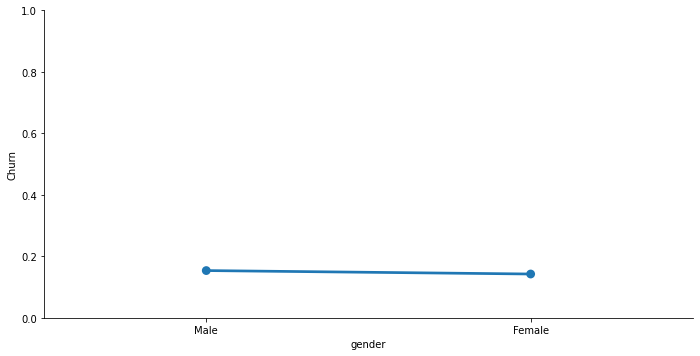

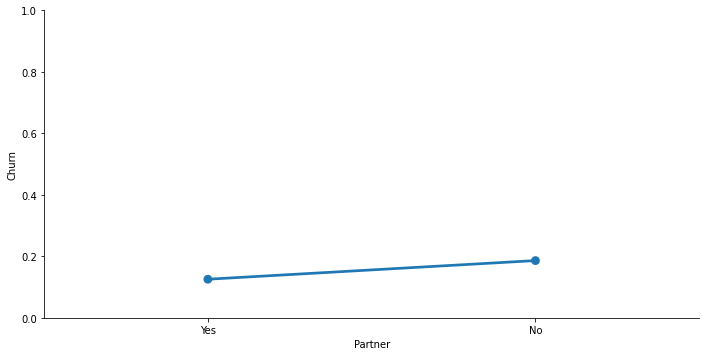

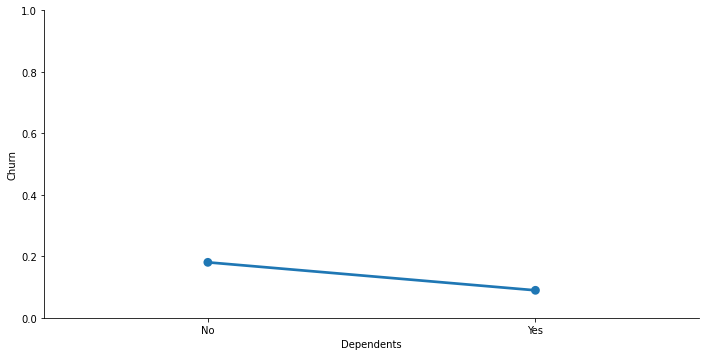

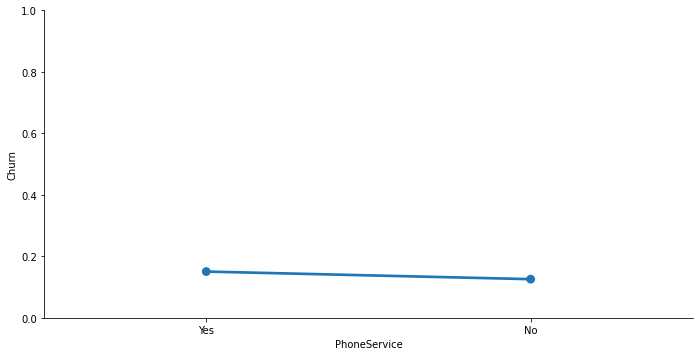

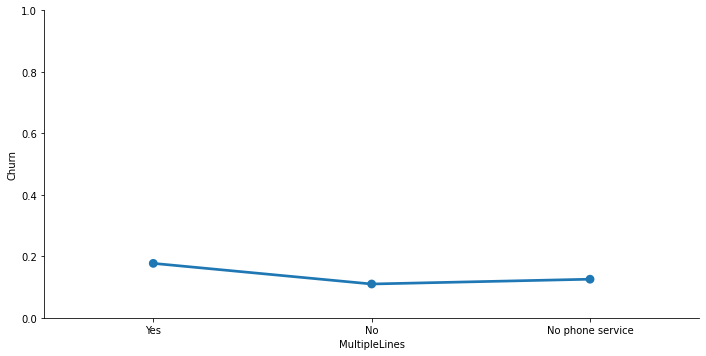

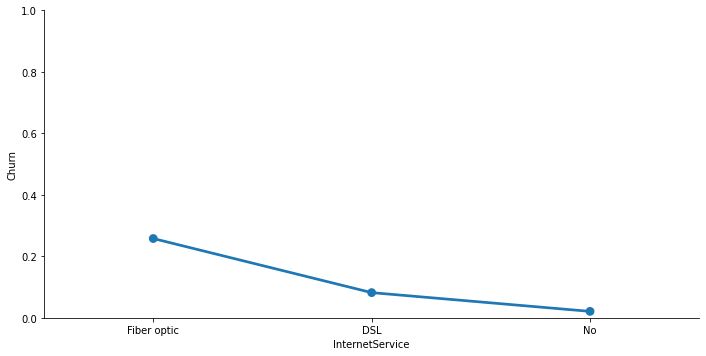

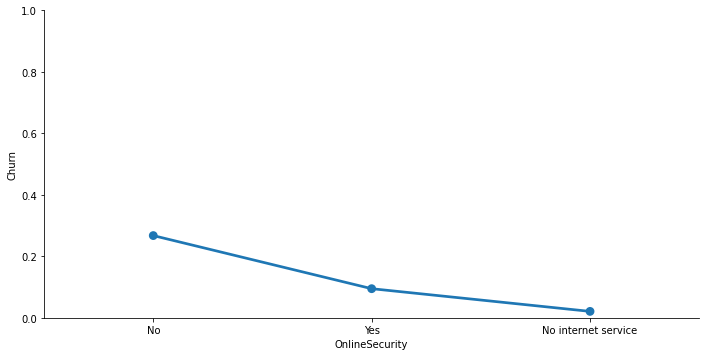

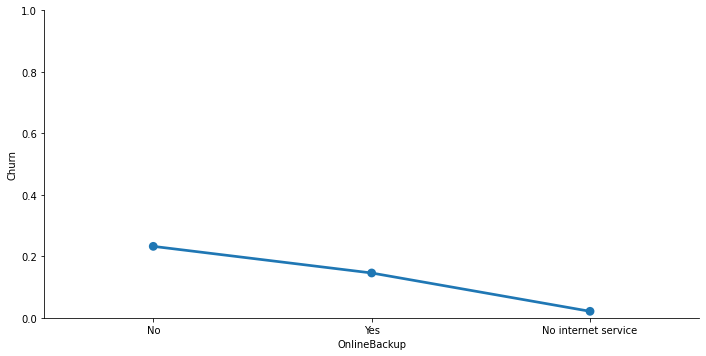

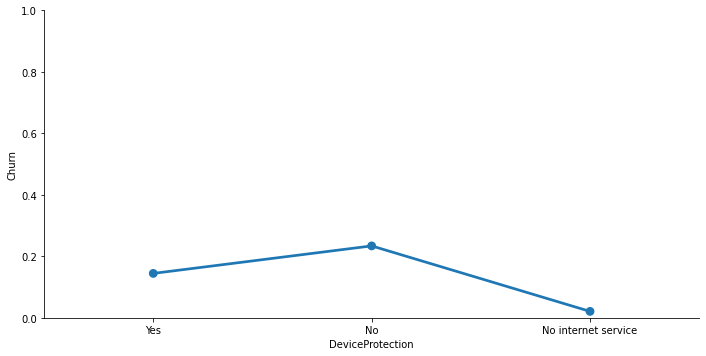

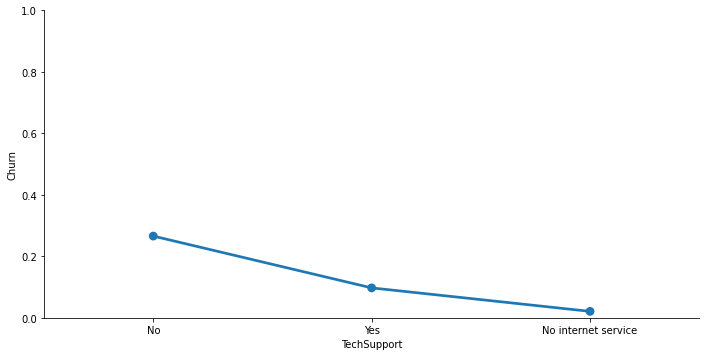

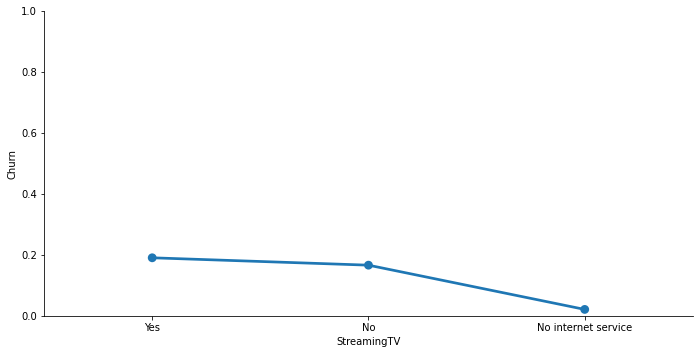

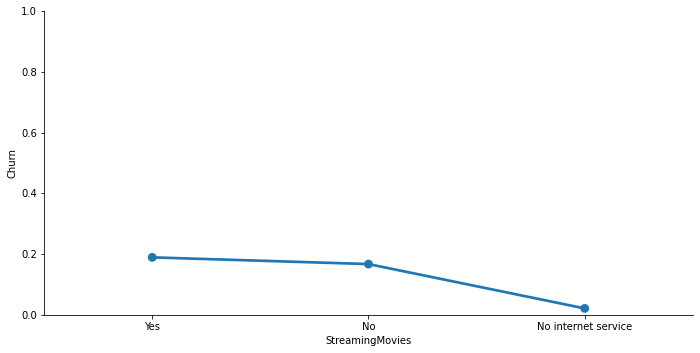

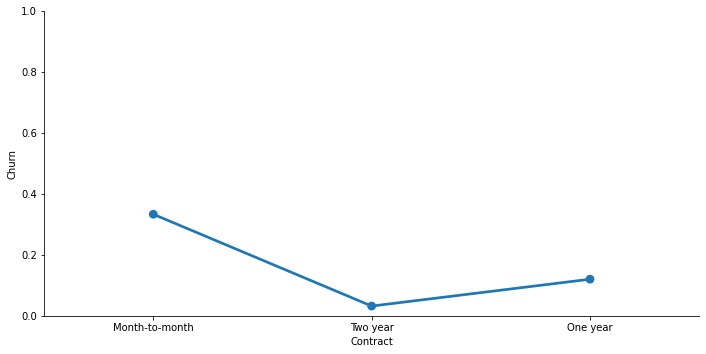

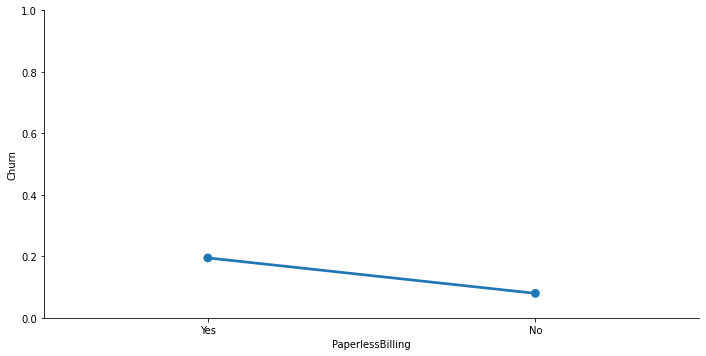

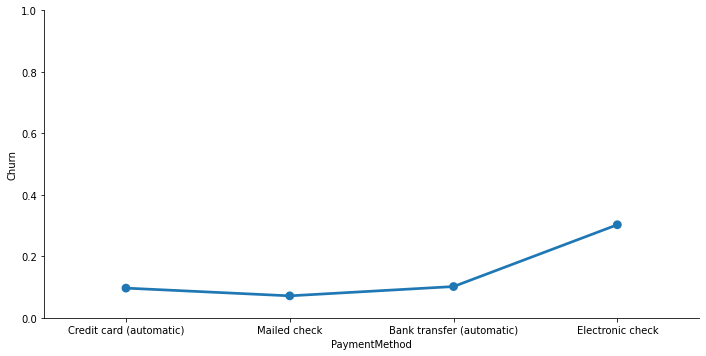

In [ ]:
for col in categorical_columns:
  if col != 'customerID' and col != 'Label':
    sns.catplot(x=col, y = 'Churn', data = df.toPandas(), kind = 'point', aspect=2, )
    plt.ylim(0,1)

# missing values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

for column in data.columns:
  missing_count = data.select([count(when(isnan(column) | col(column).isNull() , True))]).collect()[0][0]
  print(column + ': '+ str(missing_count))


customerID: 193
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0
tenure: 0
PhoneService: 0
MultipleLines: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0
Contract: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 47
Label: 0
customerTitle: 0


# remove records with empty label

In [7]:
data=data.where(data['Label'].isNull()== False)

# add a new column based on customerID

In [8]:
from pyspark.sql.functions import udf

@udf
def extractor(id):
  if id is None:
      return None
  else:
      return id.split('-')[1]

data = data.withColumn("customerTitle", extractor('customerID'))

## fill missing values of MultipleLines based on PhoneService

In [9]:
import pyspark.sql.functions as F
from pyspark.sql.functions import count , col, when

data = data.withColumn(
    'MultipleLines', 
    F.coalesce(
        F.col('MultipleLines'),
        F.when(F.col('PhoneService') == 'No', 'No phone service')
    )
)

missing_count = data.select([count(when(F.col('MultipleLines').isNull() , True))]).collect()[0][0]
print(missing_count)

161


In [10]:
data = data.withColumn(
    'PhoneService', 
    F.coalesce(
        F.col('PhoneService'),
        F.when(F.col('MultipleLines') == 'No phone service', 'No')
    )
)

missing_count = data.select([count(when(F.col('PhoneService').isNull() , True))]).collect()[0][0]
print(missing_count)

164


In [11]:
cols = ['DeviceProtection', 'OnlineBackup', 'TechSupport', 'OnlineSecurity', 'StreamingTV', 'StreamingMovies' ]

for c in cols:
  data = data.withColumn(
      c, 
      F.coalesce(
          F.col(c),
          F.when(F.col('InternetService') == 'No', 'No internet service')
      )
  )

for c in cols:
  missing_count = data.select([count(when(F.col(c).isNull() , True))]).collect()[0][0]
  print('new missing values count of '+ c + 'is: '+ str(missing_count))

new missing values count of DeviceProtectionis: 145
new missing values count of OnlineBackupis: 145
new missing values count of TechSupportis: 165
new missing values count of OnlineSecurityis: 133
new missing values count of StreamingTVis: 153
new missing values count of StreamingMoviesis: 125


In [12]:
cols = ['DeviceProtection', 'OnlineBackup', 'TechSupport', 'OnlineSecurity', 'StreamingTV', 'StreamingMovies' ]


data = data.withColumn(
    'InternetService', 
    F.coalesce(
        F.col('InternetService'),
        F.when((F.col('DeviceProtection') == 'No internet service')|
               (F.col('OnlineBackup') == 'No internet service')|
               (F.col('TechSupport') == 'No internet service')|
               (F.col('OnlineSecurity') == 'No internet service')|
               (F.col('StreamingTV') == 'No internet service')|
               (F.col('StreamingMovies') == 'No internet service')
               , 'No')
    )
)

missing_count = data.select([count(when(F.col('InternetService').isNull() , True))]).collect()[0][0]
print('new missing values count of InternetService: '+ str(missing_count))

new missing values count of InternetService: 115


In [20]:
from pyspark.sql.functions import coalesce
data = data.withColumn("TotalCharges",coalesce(data.TotalCharges, (data.tenure * data.MonthlyCharges)))

missing_count = data.select([count(when(F.col('TotalCharges').isNull() , True))]).collect()[0][0]
print('new missing values count of TotalCharges: '+ str(missing_count))

new missing values count of TotalCharges: 0


In [14]:
from pyspark.sql.functions import ceil

data = data.withColumn("tenure",coalesce(data.tenure, (ceil(data.TotalCharges / data.MonthlyCharges))))

missing_count = data.select([count(when(F.col('tenure').isNull() , True))]).collect()[0][0]
print('new missing values count of tenure: '+ str(missing_count))

new missing values count of tenure: 95


In [18]:
data = data.withColumn("MonthlyCharges",coalesce(data.MonthlyCharges, (ceil(data.TotalCharges / data.tenure))))

missing_count = data.select([count(when(F.col('MonthlyCharges').isNull() , True))]).collect()[0][0]
print('new missing values count of MonthlyCharges: '+ str(missing_count))

new missing values count of MonthlyCharges: 47


## replacing null values with *mode*

In [16]:
columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
columns.remove('customerID')
columns.remove('Label')
columns.append('tenure')
columns.append('SeniorCitizen')

for column in columns:
  grouped = data.groupBy(column).count()
  grouped = grouped.withColumn("count", grouped["count"]).orderBy('count', ascending=False)
  mode = grouped.first()[0]
  if mode == None:
    mode = grouped.collect()[1][0]
  data = data.na.fill(value=mode,subset=[column])

## replacing with mean

In [19]:
df_mean = data.agg({'MonthlyCharges': 'mean'}).collect()
mean = df_mean[0][0]
data = data.na.fill(value=mean,subset=['MonthlyCharges'])

## encoding categorical features

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

categorical_columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
categorical_columns.remove('customerID')
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in categorical_columns ]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(data).transform(data)

var = ['tenure_index', 'SeniorCitizen_index']
df_r.drop(*tuple(var))
df_r.show()

+--------------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+-------------------+
|    customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|customerTitle|gender_index|Partner_in

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+----------------------+--------------------+--------------------+---------------------+--------------------+----------------------+--------------------+--------------------+--------------------+
|       SeniorCitizen|              tenure|      MonthlyCharges|        TotalCharges|        gender_index|       Partner_index|    Dependents_index|  PhoneService_index| MultipleLines_index|InternetService_index|OnlineSecurity_index|  OnlineBackup_index|DeviceProtection_index|   TechSupport_index|   StreamingTV_index|StreamingMovies_index|      Contract_index|PaperlessBilling_index| PaymentMethod_index|         Label_index| customerTitle_index|
+--------------------+--------------------+--------------------+--------------------+-----------------

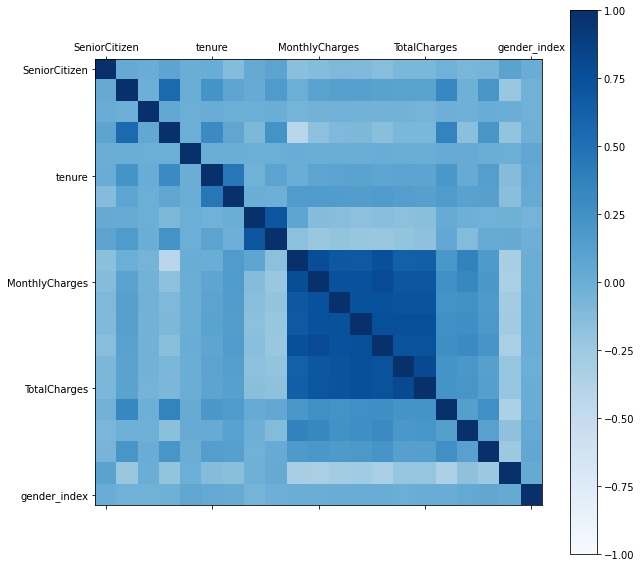

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

new_df = df_r.drop(*tuple(categorical_columns))
new_df = new_df.drop('customerID_index')
new_df = new_df.drop('customerID')

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=new_df.columns, 
                            outputCol=vector_col)
myGraph_vector = assembler.transform(new_df).select(vector_col)
matrix = Correlation.corr(myGraph_vector, vector_col)

matrix = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

df = sc.createDataFrame(corrmatrix,new_df.columns)
df.show()

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(figsize=(10, 10))
    ax=fig.add_subplot(111)
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1, cmap="Blues")
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, new_df.columns, 234)

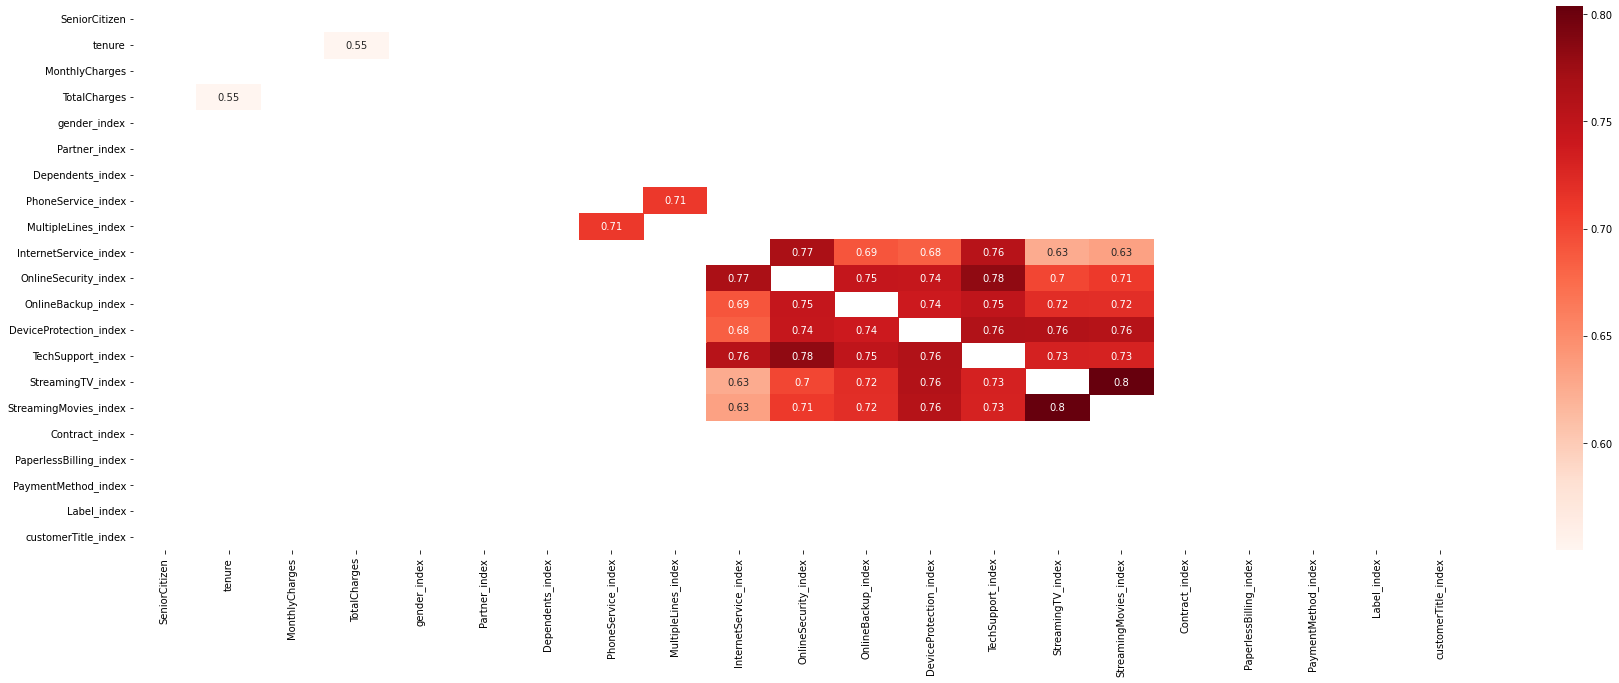

In [46]:
import seaborn as sns

pdf = new_df.toPandas()
dfCorr = pdf.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [41]:
for c in new_df.columns:
  correlation = new_df.corr(c, 'Label_index')
  print(c + " :" + str(correlation))

SeniorCitizen :0.09557175781318236
tenure :-0.22916972579259243
MonthlyCharges :0.0053712509074132385
TotalCharges :-0.19636962947107456
gender_index :-0.0076235592600129715
Partner_index :-0.1293154007841055
Dependents_index :-0.15347149712308727
PhoneService_index :-0.01820502804347562
MultipleLines_index :0.027302767869401372
InternetService_index :-0.3134956625648033
OnlineSecurity_index :-0.3249908967284684
OnlineBackup_index :-0.28802383939335624
DeviceProtection_index :-0.2670350011841469
TechSupport_index :-0.32452846851917355
StreamingTV_index :-0.2098046906855223
StreamingMovies_index :-0.2080535230015538
Contract_index :-0.33911463615995696
PaperlessBilling_index :-0.1789111955133543
PaymentMethod_index :-0.24508769277913753
Label_index :1.0
customerTitle_index :0.034820057269522434


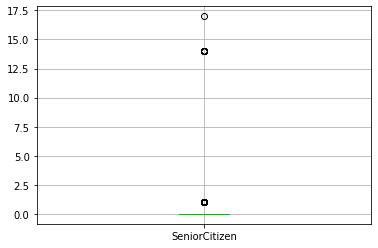

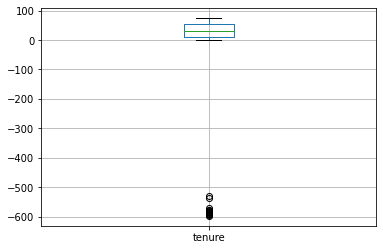

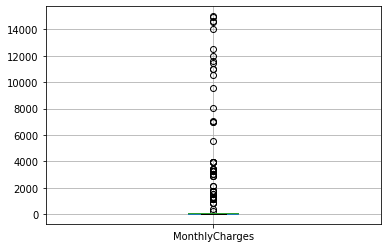

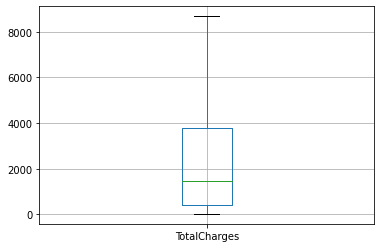

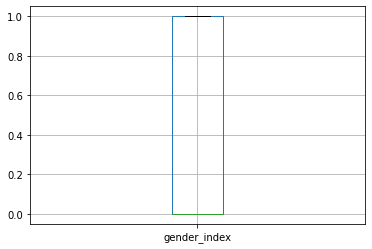

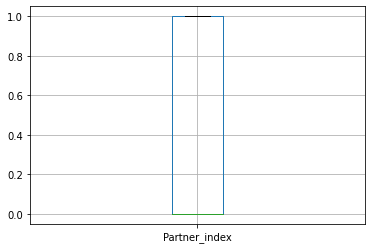

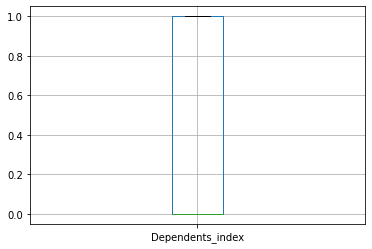

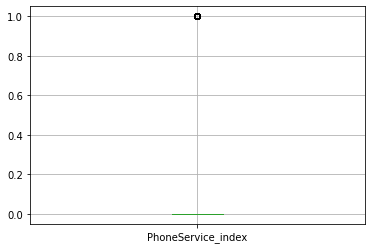

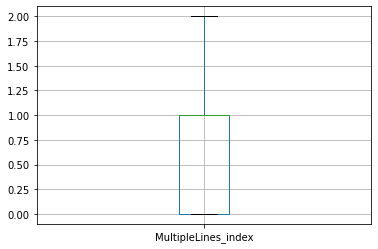

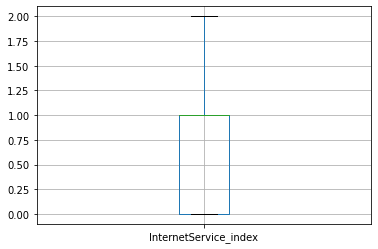

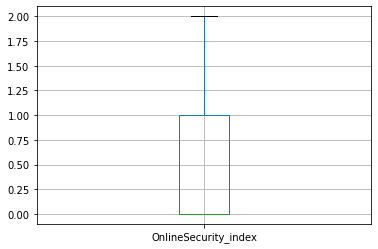

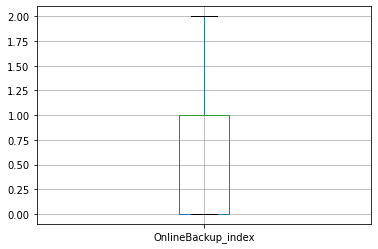

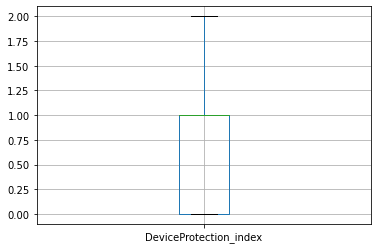

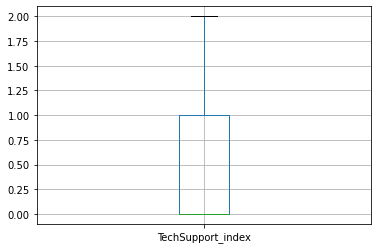

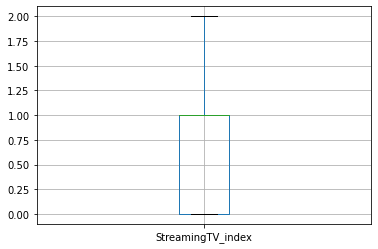

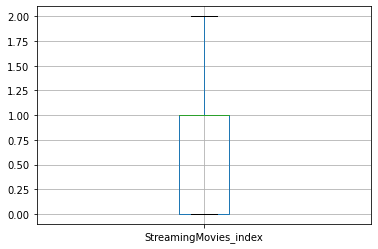

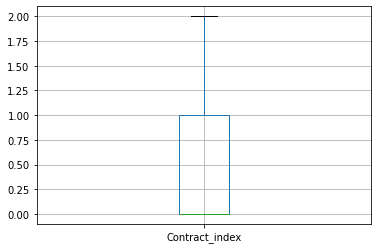

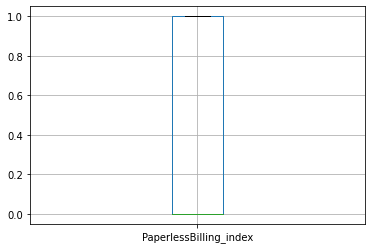

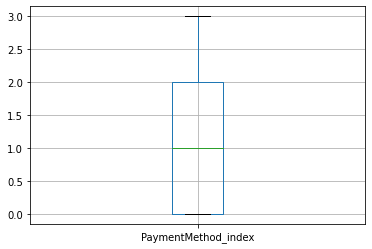

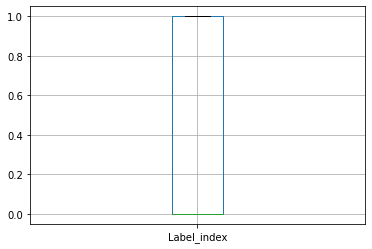

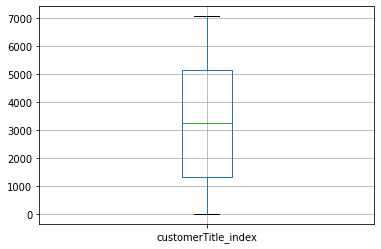

In [38]:
import matplotlib.pyplot as plt

for c in new_df.columns:
  new_df.toPandas().boxplot(column= c)
  plt.show()

In [47]:
cleaned_data.groupby('PhoneService').count().show()

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  809|
|         Yes| 6821|
+------------+-----+



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


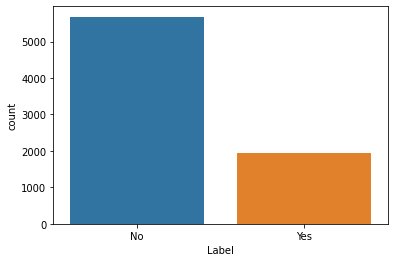

In [58]:
df1 = cleaned_data.toPandas()
g = sns.countplot(df1['Label'])
g.set_xticklabels(['No','Yes'])
plt.show()

In [21]:
unimportant_features = ['customerID', 'StreamingTV']
cleaned_data = data.drop(*tuple(unimportant_features))

In [ ]:
path = '/content/drive/My Drive/cleaned_data.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  cleaned_data.toPandas().to_csv(f)

In [23]:
path = '/content/drive/My Drive/cleaned_data_without_duplicate.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  cleaned_data.toPandas().to_csv(f)